# 1. Recurrent Neural Networks basics

**Objective**

- Understanding RNN capabilities with toy problems;
- Getting familiar with `torch` RNN tools.

**Resources and references**
- [Stanford cheat-sheet on RNNs](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks#overview)
- Andrej Karpathy, ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- J. Brownlee, ["5 Examples of Simple Sequence Prediction Problems for LSTMs"](https://machinelearningmastery.com/sequence-prediction-problems-learning-lstm-recurrent-neural-networks/)
- [Christopher Olah's blog about LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) (all his blog posts are great by the way)
- [A very nice experimentation to play with LSTM](https://distill.pub/2016/handwriting/) (to go further)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Summary

- **1. Working with RNNs in PyTorch**
  - *Elman's RNN*
  - *Running an RNN*
  - *What's happening inside?*
- **2. Task typology**
    - *Overview*
    - *2.1. Toy problem: Many-to-one*
    - *2.2. Toy problem: One-to-many*
- **3. Project: handwriting synthesis**

## 1. Working with RNNs

RNNs are a little bit different from their classical feedfoward cousins (you know their most common flavor: multilayerd perceptrons.)

In a feedforward networks, fome function $f_{w,b}$ is applied on inputs $x$ to compute output $y$:

<p align="center">
  <img src="./static/perceptron.png" />
</p>

$$
y = f_{w,b}(x) = act(\sum_i w_i x_i + b)
$$

$w$ (and $b$) are parameters of the network, and represents the weights of the connections between the neurons and their inputs (and a constant bias parameter). $act$ is the activation function.

RNN are just slightly different: they take as input not only $x$, the current input, but also some of their previous computations $h$. In the simplest case, $h$ is equivalent to the output $y$ of our perceptron. We call it **the internal or hidden state**.

$$
y_t = h_t = act(\sum_i w^{in}_i x_{t, i} + \sum_j w^h h_{t-1, j} + b)
$$

<p align="center">
  <img src="./static/rnn.png" />
</p>


Note how we added some indices $t$ everywhere: now **time matters**. Your data points $x$ are no longer independent from each other, they form **sequences**, as we have seen in previous chapter.

As simple RNNs are really just perceptrons with a supplementary input playing the role of a memory tape, we can also represent an RNN as a repeated application of a perceptron with two different inputs ($x_t$ and $h_{t-1}$):

<p align="center">
  <img src="./static/rnn-unfold.png" />
</p>

We will call this kind of representation **unfolded representations**, as recurrence and time are projected on the horizontal axis.

The perceptron is here first applied at time $t$ on $x_t$ and $h_{t-1}$, its previous internal state. We have defined two different sets of weights $w_{in}$ and $w_h$ to parameterize the neuron, but this does not change much to the equation. Once the new state $h_{t}$ is computed, we move on to the next input $x_{t+1}$, and so on.

#### Elman's RNN

The neuron we have just defined is the building block of **Elman networks**, (from Jeffrey Locke Elman, their inventor).
Elman's network, also called "simple RNNs" or just "RNNs", usually define an additional set of output weights to compute $y_t$ from $h_t$. This is like adding a layer of connections on top the internal state $h_t$ to perform the task we want (prediction, classification...)

Simple RNNs are available in Pytorch through the [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) class. They do not implement the any output layer of weights. It will be up to you to add some more computations on top of some $h_t$ to perform your task. For now, let's look at how those neural networks work wihtout performing any task.

In [ ]:
# Create an 100-neurons RNN dealing with one dimensional inputs
rnn = ...

In [ ]:
print("Wh weights shape:", rnn.weight_hh_l0.shape)
print("Win weights shape:", rnn.weight_ih_l0.shape)

#### Running an RNN

Let's try running the RNN on some dummy data, here two succesive sine waves with different frequencies.

In [ ]:
wave1 = np.sin(np.linspace(0, 4*np.pi, 100, endpoint=False))  # just some sinusoidal waves
wave2 = np.sin(np.linspace(4*np.pi, 8*np.pi, 100)*5)

wave = np.concatenate([wave1, wave2])

plt.plot(wave)
plt.show()

In [ ]:
# Always convert arrays to torch.Tensor!
x = torch.Tensor(wave)

# RNNs expect inputs of shape (sequence length, input dimension) (or (batch_size, sequence_length, input_dimension))
# so here we need to reshape x from (100,) to (100, 1) (or (1, 100, 1))
x =  ...

In [ ]:
with torch.no_grad():  # deactivate automatic gradient computation, we don't need it here
    # Apply the RNN on the wave. What are the outputs representing?
    all_outputs, last_output = ...

print(all_outputs.size(), "\n", last_output.size())
print(all_outputs, "\n", last_output)

#### What's happening inside?

Our 100-dimensional vectors represent the hidden states of our 100 neurons, for all input data steps.
Let's have a look at those hidden states.

In [ ]:
# Plot the activity of some random neurons inside the RNN
...
# The activity of all neurons inside the RNN at a timestep t is called the "hidden_state".

## Task typology

### Overview: What do we do with it ?

There are many ways of using RNNs in a neural network architecture, as they allow to fold and unfold time in your data.


For instance, you can imagine generating long captions for single images, going from a static component (an image) to a sequence of words of any length. On the contrary, a sequence of words could be compressed into a single label representing overall sentiment of a sentence ("happy" or "sad"). Or, you can use RNNs to translate a French sentence of size $n$ into an English sentence of size $m$. 

As you can see, RNNs allow to play along the time axis in various manners, depending on the task at hand, which make them incredibly more powerful than feedforwad neural networks in many situations.

In the following figures, green vectors $x$ represent input sequence or vector, green vector $a$ represents hidden states, and red vectors $y$ represent output of the neural network, which can be equal to $a$ or post-processed by some other neural network, like a layer of neurons trained to output class probabilities. RNNs are represented unfolded in time to make sequences apparent.

These variations of RNN behavior fall into four main classes of networks.

- **Many-to-many models**: from a sequence/timeseries, output another sequence/timeseries of **same length.** Ex: online speech recognition.
<p align="center">
  <img src="./static/rnn-many-to-many-same-ltr.png" width=500/>
</p>

- **Many-to-one, or seq-to-vec models**: from a sequence, output a single vector. Ex: sequence classification tasks, like sentence sentiment analysis.
<p align="center">
  <img src="./static/rnn-many-to-one-ltr.png" width=500/>
</p>

- **One-to-many, or vec-to-seq models**: from a single vector, output a sequence. Ex: image captionning or music generation.
<p align="center">
  <img src="./static/rnn-one-to-many-ltr.png" width=500/>
</p>

- **Encoder-decoder models**: from a sequence/timeseries, output another sequence/timeseries of **different length.** Ex: machine translation.
<p align="center">
  <img src="./static/rnn-many-to-many-different-ltr.png" width=500/>
</p>


### Many-to-one: the pocket calculator network

Let's design a neural network able to perform a **simple classfication task**: *tell if an arithmetical expression will give negative or positive results.*

Inputs are sequences of numbers as follow:

- every step of input is made of two number: an operand and an operator.
- the first number (the operand) is the number on which we will perform the operation
- the second number (the operator) is either 1 or 0. 1 indicates that we want to add that number to the total, 0 indicates that we want to substract that number.

Hence, the following expression:
$$+ 1 + 2 - 5 + 4 - 6$$

is represented by the input sequence:

```
[[1, 1], 
 [2, 1], 
 [5, 0], 
 [4, 1],
 [6, 0]]
```

The target class is the expected sign of the total (here  -4, so **negative class**)

All sequences are 5 operands long. All operands are single digits (0 to 9).

In [ ]:
def make_operand_sequences(n_sequences, seq_length=5):
    digits = list(range(0, 10))
    operators = [0, 1]
    op_symbols = ["-", "+"]
    x = np.zeros((n_sequences, seq_length, 2))
    y = np.zeros(n_sequences)
    for i in range(n_sequences):
        operands = np.random.choice(digits, seq_length, replace=True)
        ops = np.random.choice(operators, seq_length, replace=True)
        seq = np.vstack([operands, ops])
        x[i] = seq.T
        expr = ""
        for digit, op in zip(operands, ops):
            expr += op_symbols[operators.index(op)] + str(digit)
        total = eval(expr)
        y[i] = 1 if total > 0 else 0
    return x, y

In [ ]:
x, y = make_operand_sequences(1000)

In [ ]:
class Calculator(torch.nn.Module):

    def __init__(self, hidden_size):
        super().__init__()
        
        # Remember you can store and do everything 
        # you need in nn.Module objects
        # by defining your own methods and attributes.
        # Pytorch is very permissive!
        
        # Number of neurons in the RNN
        self.hidden_size = hidden_size
        
        # Create an RNN for the task
        # and do not forget batch_first=True
        # and an output classification layer
        self.rnn = ...
        self.fc = ...

        # Note that we won't add an activation function like softmax to the last layer
        # for now. Pytorch prefers training classifier using unormalized
        # outputs when choosing cross-entropy loss (see documentation).

    def forward(self, x):
        # Perform forward (prediction) pass.
        # Get only the last state on a sequence and pass it to the classification layer.
        # This state will represent the accumulated information
        # along the sequence of inputs.
        
        ...
        
        output = ...
        
        return output

In [ ]:
device = "cpu"  # change it to "cuda" if you can run on GPU

network = Calculator(hidden_size=100).to(device)

print(network)

#### Training loop ####
num_epochs = 50  # change it as you wish

network.train()  # training mode: on

# Loss: cross entropy (this is a classfication task!)
criterion = torch.nn.CrossEntropyLoss()

# Learning rule (optimizer). We will go with a refinement
# of the gradient descent, called Adam.
opt = torch.optim.Adam(network.parameters(), lr=1e-3)


# Convert everything to torch.Tensor and create a Dataset and 
# a DataLoader objects.
# They are used to hold your data during training, and help
# you define batch size or data transformations for instance.
# For now, we need only a simple TensorDataset (taking Tensors as 
# inputs) and a DataLoader with our chosen batch size.
batch_size = 10  # change it as you wish

x_train = torch.Tensor(x).to(device)
y_train = torch.Tensor(y).to(torch.long).to(device)  # class labels must be converted to torch.long

# Create TensorDataset and DataLoader
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

losses = []
for e in range(num_epochs):

    epoch_loss = []

    for x_i, y_i in dataloader:  # for each batch of data
        
        # training loop !
        ...
        
        loss = ...

        # Save loss values somewhere to plot the learning curve
        loss = loss.detach().numpy()
        epoch_loss.append(loss)
        
        print(f"Epoch {e} - Loss {np.mean(epoch_loss):.3f}", end="\r")

    losses.append(np.mean(epoch_loss))

In [ ]:
plt.plot(losses)

In [ ]:
x_test, y_test = make_operand_sequences(100)

In [ ]:
# Test network
network.eval()
with torch.no_grad():
    y_pred = network(torch.Tensor(x_test))

In [ ]:
print("Accuracy:", np.sum(np.argmax(y_pred.numpy(), axis=1) == y_test) / 100)

### One-to-many: the oscillator

One-to-many networks require a bit of mental exercise to set up a task properly. In the following example, we will try to solve a rather simple problem: can we train an RNN to generate a sinusoidal wave (many outputs) given a frequency as (single) input?

To generate a sequence from a vector, an RNN needs two conditions (which will recall the basic recurrence reasoning in maths; hence the name of RNN):
- a good initial condition;
- a recurrence relationship between RNN's outputs.

<p align="center">
  <img src="./static/rnn-one-to-many-ltr.png" width=500/>
</p>

The initial condition here is the green $x$ in the figure, or the "one" in "one-to-many". It is here to drive the network in an initial state from which it can autonomously generate the whole sequence. In our case, this could be a simple one-hot vector representing the frequency of the sinusoidal wave we want to generate. 

This $x$ can be fed to the network as a first input before the network receives its own previous outputs as input. This is exactly what can be seen in the schema. This is called a pre-inject.

Other techniques exist. $x$ can also be used directly as a first hidden state for the RNN. This is called an init-inject. Or $x$ can be added to the network outputs at every timestep, like a constant reminder of the initial goal. This is called a par-inject.

Once the initialization is done, the network will then work on its own outputs to generate the whole sequence, by recurrence.

In this example, we will do an init-inject initialization. We will project the 3-d vector holding frequency information into hidden state space, and use the result to initialize the first hidden state of the network (which is initialize to 0 by default). This can be done by adding a layer of connections between the frequency vector and the hidden space, that will "reshape" the frequency vector to be as big as the hidden state vector. Once reshaped, the transformed frequency can be directly fed as hidden state input to the RNN.

From there, the network will have to predict a first point of the wave. This point will serve as next input to the network, and so on.


In [ ]:
def make_waves(n_sequences, frequencies, length):
    x = np.zeros((n_sequences, 1, len(frequencies)))
    y = np.zeros((n_sequences, length, 1))
    for i in range(n_sequences):
        fs = np.random.choice(frequencies)
        waves = np.sin(2*np.pi*fs*np.linspace(0, 1, length))
        fs_idx = frequencies.index(fs)
        x[i, 0, fs_idx] = 1  # one hot encode frequencies: 0 for all, 1 for the current frequency
        y[i, :, 0] = waves
    
    # return shape (n, length, 1)
    return x, y

In [ ]:
frequencies = [1, 5, 10]  # frequency values
length = 50  # length of the sinusoidal wave

x, y = make_waves(1000, frequencies, length)

In [ ]:
# Shape: [n, length, dimension]
# Note that length is 1 here, as we only give a single input to the network.
# One x per wave, representing the frequency class
print(x.shape, "\n", x)

In [ ]:
class SineWaveGenerator(torch.nn.Module):

    def __init__(self, hidden_size, n_frequencies, length):
        super().__init__()

        self.hidden_size = hidden_size
        self.length = length

        # Create a layer to transform frequency into hidden states
        self.input_to_hidden = ...
        # Create an RNN
        self.rnn = ...
        # Create an output layer to transform hidden states into a 1-d point of sinusoidal wave
        self.hidden_to_output = ...

    def forward(self, freq):
                
        # store outputs
        outputs = torch.zeros(x.size(0), self.length, 1).to(freq.device)
        
        # Mind the shapes here:
        # RNN outputs do not support batch_first=True... 
        # You may need to transpose things to keep everything coherent.

        # init-inject
        # You should go from input vector of shape [n, 1, frequencies]
        # to init hidden state of shape [1, n, hidden_size]
        
        hidden = ...
        
        # first input is null
        # zeros: [n, length=1, dim]
        x = ...
        
        # Generate the wave by recurrence
        for i in range(0, self.length):
                
            y = ...
            
            # store outputs
            outputs[:, i, 0] = y.squeeze()
            
            # Use output as next input
            x = y
            
        return outputs

In [ ]:
network = SineWaveGenerator(hidden_size=100, n_frequencies=3, length=length)

print(network)

# Training loop
num_epochs = 10
batch_size = 10

losses = []

# Ok now do it yourselves

In [ ]:
plt.plot(losses)

In [ ]:
x_test, y_test = make_waves(100, frequencies, length)

In [ ]:
network.eval()
with torch.no_grad():
    y_pred = network(torch.Tensor(x_test))

In [ ]:
print("MSE:", np.mean((y_test - y_pred.numpy())**2))

# Application to non stationary time series
## 1. Airline passengers dataset

Here we will train RNN to predict some non-stationary time series. We will start with the well-kown "airline passengers" dataset.

Dataset downloaded successfully as 'airline-passengers.csv'

Dataset shape: (144, 2)
Columns: ['Month', 'Passengers']

First few rows:
     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


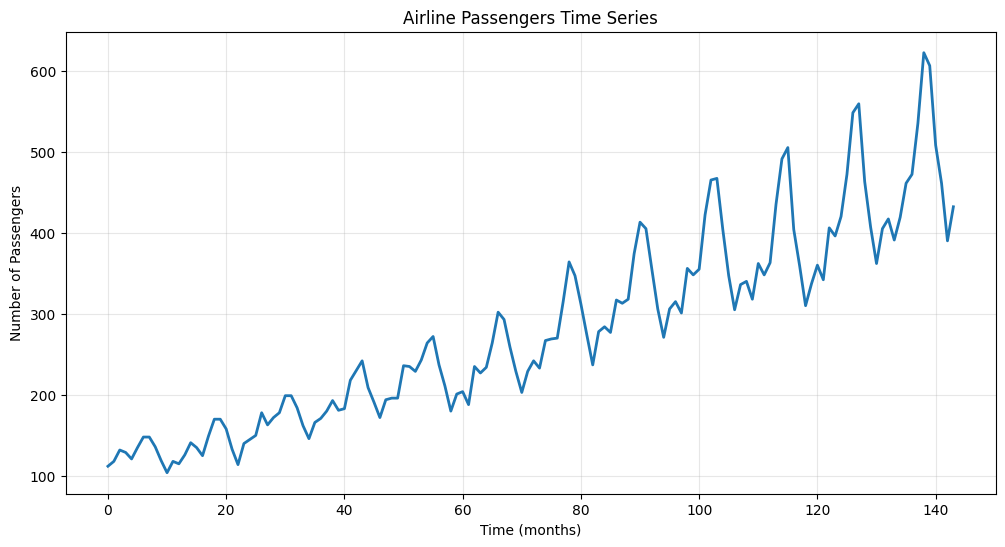

In [14]:
import pandas as pd
import urllib.request   

# Download the dataset using urllib
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
filename = "airline-passengers.csv"

try:
    urllib.request.urlretrieve(url, filename)
    print(f"Dataset downloaded successfully as '{filename}'")
    
    # Load and preview the data
    data = pd.read_csv(filename)
    print(f"\nDataset shape: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")
    print("\nFirst few rows:")
    print(data.head())
    
    # Plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[:, 1], linewidth=2)
    plt.title('Airline Passengers Time Series')
    plt.xlabel('Time (months)')
    plt.ylabel('Number of Passengers')
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("You can manually download from: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

In [15]:
# Prepare data for RNN training
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Extract the passenger data (second column)
passengers = data.iloc[:, 1].values.astype(float)

# Normalize the data
scaler = MinMaxScaler()
passengers_normalized = scaler.fit_transform(passengers.reshape(-1, 1)).flatten()

# Create sequences for RNN
def create_sequences(data, sequence_length):
    """Create input-output sequences for time series prediction"""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 12  # Use 12 months to predict next month
test_size = 0.2

# Create sequences
X, y = create_sequences(passengers_normalized, sequence_length)

# Split into train and test
split_index = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for PyTorch RNN (samples, sequence_length, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Training data shape: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
print(f"Test data shape: X={X_test_tensor.shape}, y={y_test_tensor.shape}")

# Define RNN model for time series prediction
class TimeSeriesRNN(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(TimeSeriesRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward pass through RNN
        out, _ = self.rnn(x, h0)
        
        # Get the last time step output
        out = self.fc(out[:, -1, :])
        return out

# Create model
model = TimeSeriesRNN(input_size=1, hidden_size=50, num_layers=2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("\n Model created successfully!")
print(model)

Training data shape: X=torch.Size([105, 12, 1]), y=torch.Size([105])
Test data shape: X=torch.Size([27, 12, 1]), y=torch.Size([27])

 Model created successfully!
TimeSeriesRNN(
  (rnn): RNN(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


Training the RNN model...
Epoch [40/200], Loss: 0.007792
Epoch [80/200], Loss: 0.004861
Epoch [120/200], Loss: 0.003502
Epoch [80/200], Loss: 0.004861
Epoch [120/200], Loss: 0.003502
Epoch [160/200], Loss: 0.002149
Epoch [200/200], Loss: 0.001814
Training completed!
Epoch [160/200], Loss: 0.002149
Epoch [200/200], Loss: 0.001814
Training completed!


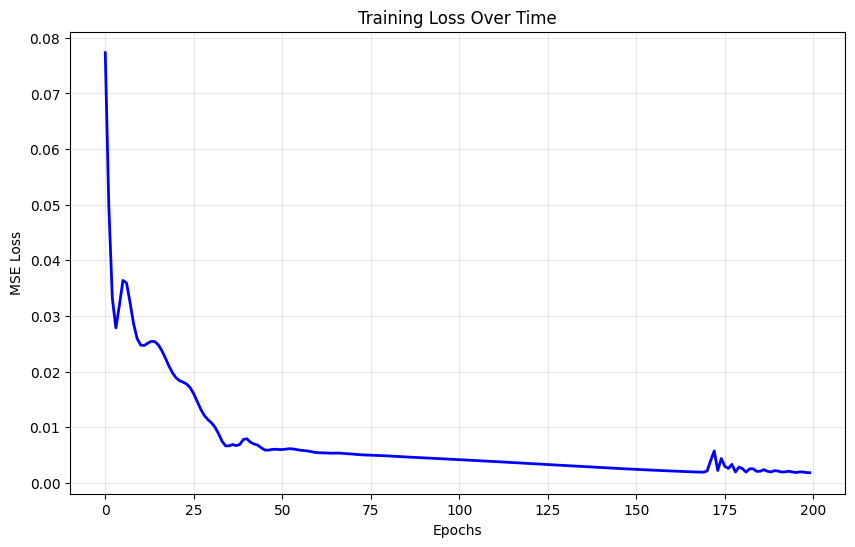

In [16]:
# Train the RNN model
num_epochs = 200
train_losses = []

print("Training the RNN model...")

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 40 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, color='blue')
plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)
plt.show()

Test Performance:
MSE: 2416.82
MAE: 36.17
RMSE: 49.16


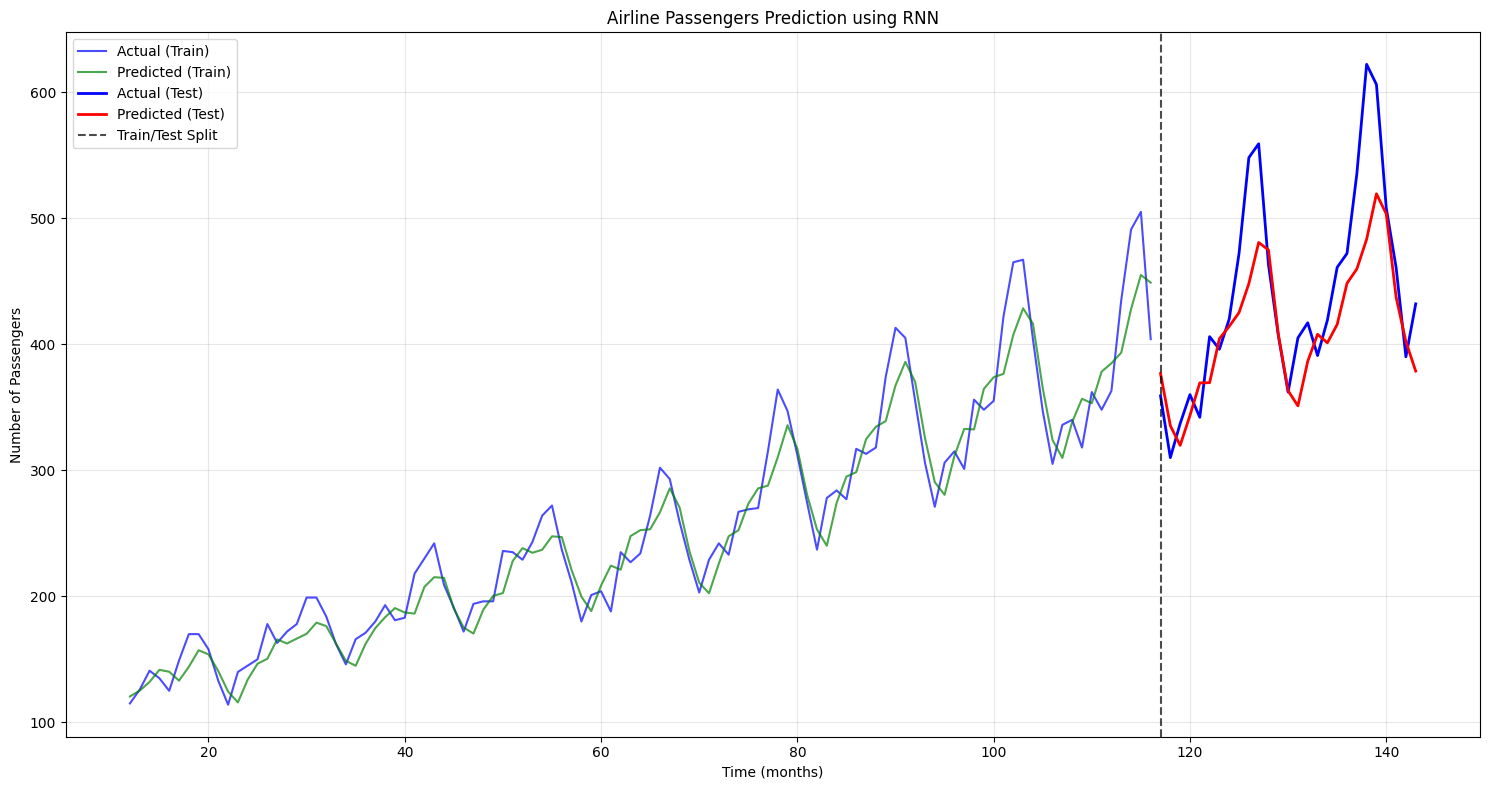


Recent Predictions vs Actual:
Month -24: Actual=360, Predicted=343, Error=17
Month -23: Actual=342, Predicted=369, Error=27
Month -22: Actual=406, Predicted=369, Error=37
Month -21: Actual=396, Predicted=404, Error=8
Month -20: Actual=420, Predicted=414, Error=6
Month -19: Actual=472, Predicted=425, Error=47
Month -18: Actual=548, Predicted=448, Error=100
Month -17: Actual=559, Predicted=481, Error=78
Month -16: Actual=463, Predicted=475, Error=12
Month -15: Actual=407, Predicted=408, Error=1
Month -14: Actual=362, Predicted=363, Error=1
Month -13: Actual=405, Predicted=351, Error=54
Month -12: Actual=417, Predicted=386, Error=31
Month -11: Actual=391, Predicted=408, Error=17
Month -10: Actual=419, Predicted=401, Error=18
Month -9: Actual=461, Predicted=416, Error=45
Month -8: Actual=472, Predicted=448, Error=24
Month -7: Actual=535, Predicted=460, Error=75
Month -6: Actual=622, Predicted=483, Error=139
Month -5: Actual=606, Predicted=519, Error=87
Month -4: Actual=508, Predicted=503,

In [18]:
# Evaluate the model and visualize predictions
model.eval()

with torch.no_grad():
    # Predictions on test set
    test_predictions = model(X_test_tensor).squeeze().numpy()
    
    # Predictions on training set (for comparison)
    train_predictions = model(X_train_tensor).squeeze().numpy()

# Denormalize predictions and actual values
test_predictions_denorm = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_actual_denorm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
train_predictions_denorm = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
train_actual_denorm = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_mse = mean_squared_error(test_actual_denorm, test_predictions_denorm)
test_mae = mean_absolute_error(test_actual_denorm, test_predictions_denorm)

print(f"Test Performance:")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"RMSE: {np.sqrt(test_mse):.2f}")

# Visualize predictions
plt.figure(figsize=(15, 8))

# Plot training data and predictions
train_time = range(sequence_length, sequence_length + len(train_actual_denorm))
plt.plot(train_time, train_actual_denorm, 'b-', label='Actual (Train)', alpha=0.7)
plt.plot(train_time, train_predictions_denorm, 'g-', label='Predicted (Train)', alpha=0.7)

# Plot test data and predictions  
test_time = range(sequence_length + len(train_actual_denorm), 
                 sequence_length + len(train_actual_denorm) + len(test_actual_denorm))
plt.plot(test_time, test_actual_denorm, 'b-', label='Actual (Test)', linewidth=2)
plt.plot(test_time, test_predictions_denorm, 'r-', label='Predicted (Test)', linewidth=2)

# Add vertical line to separate train/test
plt.axvline(x=sequence_length + len(train_actual_denorm), color='black', 
           linestyle='--', alpha=0.7, label='Train/Test Split')

plt.title('Airline Passengers Prediction using RNN')
plt.xlabel('Time (months)')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show recent predictions vs actual
print("\nRecent Predictions vs Actual:")
for i in range(-24, 0):
    print(f"Month {i}: Actual={test_actual_denorm[i]:.0f}, Predicted={test_predictions_denorm[i]:.0f}, Error={abs(test_actual_denorm[i]-test_predictions_denorm[i]):.0f}")

## Questions TODO
- How would you describe the predictions made by the RNN? Are they satisfying?

... # TO COMPLETE

- When you look at the error made by the model, could you see some tendency? or cyclicity? 

... # TO COMPLETE


## 2. Monthly beer production in Australia

Download the dataset here: https://github.com/ejgao/Time-Series-Datasets/blob/master/monthly-beer-production-in-austr.csv


In [19]:
# Make the same analysis than before (for airline passengers dataset) for this new dataset.

... # TO COMPLETE

Ellipsis